In [38]:
import encoding_tools
from pathlib import Path
import numpy as np
import pickle
import pandas as pd
from sklearn import preprocessing

# ML imports
from sklearn import linear_model
#from sklearn.cross_validation import train_test_split
# train_test_split has moved to sklearn.model_selection
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from scipy import optimize, linalg
import scipy
from sklearn.model_selection import KFold # import KFold
import matplotlib.pyplot as plt

# custom imports
import encoding_tools as encoding
import chimera_tools as chimera
import GP_tools as GP

import os

In [26]:
Processed_Folder = Path(r"Phosphotase_Encode.ipynb").parent.absolute() / Path("Processed Data")

#dicts = ['EFI_ID_List', 'metabolite_dict', 'Protein_seq_dict']

with open(Processed_Folder / Path('EFI_ID_List.p'), 'rb') as EFI_ID:
    EFI_ID_List = pickle.load(EFI_ID)

with open(Processed_Folder / Path('metabolite_dict.p'), 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)

with open(Processed_Folder / Path('Protein_seq_dict.p'), 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)

activations = pd.read_csv(Processed_Folder / Path('activations.csv'), index_col=0)

In [27]:
print("Number of metabolites: {}".format(len(metabolite_dict)))
print("Number of sequences: {}".format(len(EFI_ID_List)))

Number of metabolites: 168
Number of sequences: 218


In [28]:
# question: will simply adding a padding suffice? should we use multiple sequence alignment?
# is there any homology among the sequences?

# Need to pad protein sequences to the max length of the longest one
max_len = len(max(Protein_seq_dict.values(), key=len))
fillchar = '-' # This is whats used in the GP-UCB paper
Padded_dict = {}
OH_dict = {}
for ID in EFI_ID_List:
    Padded_dict[ID] = Protein_seq_dict[ID].upper().ljust(max_len, fillchar)
    OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

In [28]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

seqs = []

for ID in EFI_ID_List:
    seq = SeqRecord(Seq(Protein_seq_dict[ID].upper()), id=str(ID))
    seqs.append(seq)
    
SeqIO.write(seqs, "sequences.fasta", "fasta")

218

In [29]:
ID = np.random.randint(low=0,high=218)
len_comp = len(Padded_dict[EFI_ID_List[ID]])
assert len(Padded_dict[EFI_ID_List[0]]) == len(Padded_dict[EFI_ID_List[ID]])
print(len_comp)
print(ID) 

604
1


In [30]:
def ML_train(X, y):
    # test the optimization of the hyp-prams
    initial_guess = [0.9,0.9]

    # take the log of the initial guess for optimiziation 
    initial_guess_log = np.log(initial_guess)

    # optimize to fit model
    result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X,y), method='L-BFGS-B')
    
    print('Full GP regression model')
    print('Hyperparameters: ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x[1])))

    # next set of hyper prams 
    final_prams = [np.exp(result.x[0]), np.exp(result.x[1])]
    
    return final_prams

def ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_, num_iter=1, Substrate_ID=0, metabolite_dict=metabolite_dict):
    substrate = list(metabolite_dict.values())[Substrate_ID]
    
    if not os.path.exists('outputs/loop_figs/' + str(substrate) + '/'):
        os.makedirs('outputs/loop_figs/' + str(substrate) + '/')

    path_outputs = 'outputs/loop_figs/' + str(substrate) + '/'

    # next use trained GP model to predict full test set
    mu_true_test, var_true_test = GP.predict_GP(X, y, X_true_test, final_prams)

    # convert the true test predications and y back to unnormalized data
    y_test_real = np.exp(y_true_test*np.std(log_data)  + np.mean(log_data))
    mu_test_real = np.exp(mu_true_test*np.std(log_data)  + np.mean(log_data))

    if property_ != 'kinetics_off':
        
        par = np.polyfit(y_test_real, mu_test_real, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        
        # coefficient of determination, plot text
        variance = np.var(mu_test_real)
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(y_test_real, mu_test_real)])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set')
        print('R = %0.3f'% np.sqrt(Rsqr))
        
        # plot and measure correlation
        plt.figure('True test', figsize=(1.5, 1.5))
        plt.plot(y_test_real, mu_test_real, 'o', ms=3, color='k')
        
        max_x = np.max(y_test_real)
        plt.plot([0, max_x], [intercept, slope*max_x+intercept], '-', color='k')
        plt.suptitle('R = %0.3f'% np.sqrt(Rsqr))
        plt.savefig(path_outputs + str(property_)+'_matern_kernel_'+str(num_iter)+'.png', bbox_inches='tight', transparent=False, dpi=300)
        
        plt.show()

    elif property_ == 'kinetics_off':
        
        par = np.polyfit(np.log10(y_test_real), np.log10(mu_test_real), 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        
        # coefficient of determination, plot text
        variance = np.var(np.log10(mu_test_real))
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(np.log10(y_test_real), np.log10(mu_test_real))])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set')
        print('R = %0.3f'% np.sqrt(Rsqr))
        
        # plot and measure correlation
        plt.figure('True test', figsize=(1.5, 1.5))
        plt.plot(np.log10(y_test_real), np.log10(mu_test_real), 'o',  ms=3, color='k')
        
        max_x = np.max(y_test_real)
        min_x = np.min(y_test_real)
        
        plt.plot([np.log10(min_x), np.log10(max_x)], [np.log10(slope*min_x+intercept), np.log10(slope*max_x+intercept)], '-', color='k')
        
        plt.savefig(path_outputs + str(property_)+'_matern_kernel_'+str(num_iter)+'.png', bbox_inches='tight', transparent=True)
        # plt.show()

    # df_select_test_not_defined
    df_select_test = pd.DataFrame(columns=['y','mu','y_real','mu_real'])

    # export csv with predicted values
    df_select_test['y'] = y_true_test
    df_select_test['mu'] = mu_true_test
    df_select_test['y_real'] = y_test_real
    df_select_test['mu_real'] = mu_test_real

    df_select_test.to_csv(path_outputs+ 'matern_kernel_'+str(num_iter)+'_'+str(property_)+'.csv')
    return
    

In [31]:
def cross_validation(X, log_data, property_):
    path_outputs = 'outputs/loop_figs/'

    kf = KFold(n_splits=20) # Define the split
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

    mu_s = []
    var_s = []
    y_s = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

        log_data_train, log_data_test = log_data[train_index], log_data[test_index]

        y_train = (log_data_train - np.mean(log_data_train))/np.std(log_data_train)
        y_test = (log_data_test - np.mean(log_data_train))/np.std(log_data_train)

        initial_guess = [0.1,10]

        # take the log of the initial guess for optimiziation 
        initial_guess_log = np.log(initial_guess)

        # optimize to fit model
        result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X_train,y_train), method='L-BFGS-B')#,

        # next set of hyper prams 
        prams_me = [np.exp(result.x[0])**2, np.exp(result.x[1])]

        # next used trained GP model to predict on test data
        mu, var = GP.predict_GP(X_train, y_train, X_test, prams_me)
        
        # un normalize
        y_test_real = np.exp(y_test*np.std(log_data_train)  + np.mean(log_data_train))
        mu_real = np.exp(mu*np.std(log_data_train)  + np.mean(log_data_train))
        
        mu_s.append(mu)
        var_s.append(var)
        y_s.append(y_test)

    # reformat all
    y_s_all = [j for i in y_s for j in i]
    mu_s_all = [j for i in mu_s for j in i]

    # plot results
    plt.figure('My GP test set evaluation', figsize=(1.5, 1.5))
    plt.plot(y_s_all, mu_s_all, 'o', ms=3, color='k')


    # calculate correlation 
    measured = y_s_all
    predicted = mu_s_all

    par = np.polyfit(measured, predicted, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]

    # calc correlation 
    variance = np.var(predicted)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(measured, predicted)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    
    print('20-fold corss validation of GP regression model')
    print('R = %0.2f'% np.sqrt(Rsqr))

    max_x = np.max(y_s_all)
    min_x = np.min(y_s_all)
    
    plt.plot([min_x, max_x], [slope*min_x+intercept, slope*max_x+intercept], '-', color='k')
    plt.savefig(path_outputs + str(property_)+'_matern_kernel_CV_fig1.pdf', bbox_inches='tight', transparent=True)
    plt.show()
    return measured, predicted

In [32]:
# Perform CV train
# cross_validation(X=X, log_data=log_data, property_='activations')

In [33]:
'''
import matplotlib.pyplot as plt

p_length = [0]*218

for i in range(0,len(Protein_seq_dict.values())):
    p_length[i] = len(Protein_seq_dict[EFI_ID_List[i]])

plt.hist(p_length,bins=600)
plt.xlabel('Protein Sequence Length')
plt.ylabel('Number of protein sequences')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\np_length = [0]*218\n\nfor i in range(0,len(Protein_seq_dict.values())):\n    p_length[i] = len(Protein_seq_dict[EFI_ID_List[i]])\n\nplt.hist(p_length,bins=600)\nplt.xlabel('Protein Sequence Length')\nplt.ylabel('Number of protein sequences')\nplt.show()\n"

In [34]:
def data_format(X, y):
    # test data only includes gen 10
    # df_test_data = df[df.gen == 10]

    # training data excludes test data (gen 10)
    # df_data = df[df.gen != 10]

    # Clean 0 y data which skews results when having to convert infs
    X = X[y != 0]
    y = y[y != 0]

    # Use random split of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # normalize training data
    log_data = np.log(y_train)

    '''
    # Convert -infs to large negative values
    for i in range(0,len(log_data)):
        if str(log_data[i]) == '-inf':
            log_data[i] = -1000
    '''

    y_train = (log_data - np.mean(log_data))/np.std(log_data)
    # seq = df_select.seq.values

    # normalize test data
    log_data_test = np.log(y_test)
    y_test = (log_data_test - np.mean(log_data))/np.std(log_data)
    # seq_test = df_select_test.seq.values

    return log_data, X_train, X_test, y_train, y_test 
    
    # seq_test, df_select, df_select_test

In [35]:
def prep_inputs(Protein_seq_dict,EFI_ID_List,activations,Substrate_ID=0,trim_long=False):
    
    # Trim length of protein sequences first
    if trim_long == True:
        Trimmed_dict = {}
        New_ID_List = []
        for ID in EFI_ID_List:
            if len(Protein_seq_dict[ID]) <= 300:
                Trimmed_dict[ID] = Protein_seq_dict[ID]
                New_ID_List.append(ID)
        Protein_seq_dict = Trimmed_dict
        EFI_ID_List = New_ID_List
    
    # Need to pad protein sequences to the max length of the longest one
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFI_ID_List:
        Padded_dict[ID] = Protein_seq_dict[ID].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

    # Preparing input training data X to feed into ML Model
    input_len = len(OH_dict[EFI_ID_List[0]])*21
    num_inputs = len(OH_dict.keys())

    X = np.zeros((num_inputs,input_len))
    for i in range(0,len(EFI_ID_List)):
        ID = EFI_ID_List[i]
        X_seq = OH_dict[ID]
        X_seq = np.reshape(X_seq,(1,X_seq.shape[0]*21))
        X[i,:] = X_seq

    # Preapre output training data y to feed into ML Model
    dummy = [str(ID) for ID in EFI_ID_List]
    y = activations[dummy].values[Substrate_ID,:]

    '''
    # Now we need to normalize the data
    ss1 = preprocessing.StandardScaler()
    y = y.reshape(-1,1) # Single feature dataset
    y = ss1.fit_transform(y) # fit the SS1 and standardize x_train
    y = ss1.transform(y) # transform x_test
    '''
    return X, y

In [41]:
def auto_train_test(Protein_seq_dict, EFI_ID_List, activations, Substrate_ID, num_iter, metabolite_dict=metabolite_dict):
    # Need to prep inputs X and Y
    X, y = prep_inputs(Protein_seq_dict,EFI_ID_List,activations,Substrate_ID=Substrate_ID,trim_long=True)
    
    print(X)

    # Format data for train and test splits
    log_data, X_train, X_test, y_train, y_test = data_format(X, y)

    # Train ML Model on training set
    final_prams = ML_train(X_train, y_train)

    # Predict on test set
    ML_predict(X=X_train, y=y_train, X_true_test=X_test, y_true_test=y_test, log_data=log_data, final_prams=final_prams, property_='activity', num_iter=num_iter, Substrate_ID=Substrate_ID, metabolite_dict=metabolite_dict)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Full GP regression model
Hyperparameters: 7.355381921493634e-06 5.217544178374072
GP regression model test set
R = 0.100


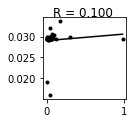

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Full GP regression model
Hyperparameters: 2.2218255120877122e-06 5.282631921174498
GP regression model test set
R = 0.000


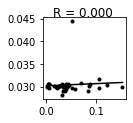

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


KeyboardInterrupt: 

In [42]:
for j in range(0,80):
    for i in range(0,20):
        try:
            auto_train_test(Protein_seq_dict, EFI_ID_List, activations, Substrate_ID=j, num_iter=i)
        except np.linalg.LinAlgError:
            print('LinAlgError, negative value in eigenvector')

In [ ]:
type(y[2])

In [ ]:
metabolite_list = list(metabolite_dict.values())

In [226]:
metabolite_dict

{'C7': 'Blank',
 'D7': 'phosphoenolpyruvate',
 'E7': 'Glycerol-2-phospate',
 'F7': 'Glycerol-3-phosphate',
 'G7': 'D-erythronate-4-phosphate',
 'H7': 'L-erythronate-4-phosphate',
 'I7': 'D-threonate-4-phosphate',
 'J7': 'Pyrophosphate',
 'K7': 'ATP',
 'L7': 'TTP',
 'M7': 'GTP',
 'N7': 'dATP',
 'C8': 'Glycolic Acid O-P',
 'D8': 'Glycerol-phosphate',
 'E8': 'DL-glyceraldehyde-3-phosphate',
 'F8': 'dihydroxyacetone phosphate',
 'G8': 'meso-erythritol-4-phosphate',
 'H8': 'D-threitol-4-phosphate',
 'I8': 'D-erythrose-4-phosphate',
 'J8': 'imidodiphosphate (PNP)',
 'K8': 'ADP',
 'L8': 'TDP',
 'M8': 'GDP',
 'N8': 'dCTP',
 'C9': 'D-2-deoxy-ribonate-5-phosphate',
 'D9': 'D-arabinonate-5-phosphate',
 'E9': 'D-lyxonate-5-phosphate',
 'F9': 'D-ribonate-5-phosphate',
 'G9': 'D-xylonate-3-phosphate',
 'H9': 'D-xylonate-5-phosphate',
 'I9': 'L-arabinonate-5-phosphate',
 'J9': 'Thiamine-pyrophosphate',
 'K9': 'UTP',
 'L9': 'CTP',
 'M9': 'ITP',
 'N9': 'dGTP',
 'C10': 'L-Ribonate-5-phosphate',
 'D10': 

In [216]:
dummy = [str(ID) for ID in EFI_ID_List]
activations[dummy].values[0,:]

array([  3.80000000e-02,   2.80000000e-02,   0.00000000e+00,
         1.50000000e-03,   3.20000000e-02,   2.65000000e-02,
         8.75000000e-02,   8.40000000e-02,   2.45000000e-02,
         5.25000000e-02,   1.10000000e-02,   5.70000000e-02,
         5.35000000e-02,   2.75000000e-02,   2.20000000e-02,
         5.50000000e-03,   5.50000000e-03,   0.00000000e+00,
         6.65000000e-02,   1.30000000e-02,   5.10000000e-02,
         1.70000000e-02,   1.05000000e-02,   1.20000000e-02,
         4.10000000e-02,   1.05000000e-01,   2.00000000e-02,
         0.00000000e+00,   5.85000000e-02,   3.40000000e-02,
         4.05000000e-02,   2.90000000e-02,   6.25000000e-02,
         6.95000000e-02,   7.35000000e-02,   4.65000000e-02,
         8.50000000e-02,   1.00000000e-03,   4.45000000e-02,
         4.30000000e-02,   9.20000000e-02,   6.75000000e-02,
         5.15000000e-02,   9.10000000e-02,   2.40000000e-02,
         2.60000000e-02,   5.50000000e-03,   1.70000000e-02,
         3.65000000e-02,